<a href="https://colab.research.google.com/github/Taylor-Tian/hello-world/blob/master/feature_sets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

 # 特征集

 **学习目标**：创建一个包含极少特征但效果与更复杂的特征集一样出色的集合

 到目前为止，我们已经将所有特征添加到了模型中。具有较少特征的模型会使用较少的资源，并且更易于维护。我们来看看能否构建这样一种模型：包含极少的住房特征，但效果与使用数据集中所有特征的模型一样出色。

 ## 设置

和之前一样，我们先加载并准备加利福尼亚州住房数据。

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.cn/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [0]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [3]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2657.0,540.1,1432.9,502.0,3.9,2.0
std,2.1,2.0,12.6,2229.5,427.0,1177.6,389.4,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,3.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1459.0,296.0,791.0,281.8,2.6,1.5
50%,34.2,-118.5,29.0,2136.0,434.0,1165.0,408.0,3.6,1.9
75%,37.7,-118.0,37.0,3161.0,650.2,1720.0,605.0,4.8,2.3
max,42.0,-114.5,52.0,37937.0,6445.0,35682.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.6,2611.8,537.7,1421.5,499.4,3.9,2.0
std,2.2,2.0,12.6,2055.9,408.2,1073.1,372.6,1.9,1.0
min,32.5,-124.3,2.0,18.0,3.0,8.0,4.0,0.5,0.0
25%,33.9,-121.8,18.0,1467.0,299.0,785.0,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2108.5,433.0,1171.5,410.0,3.5,1.9
75%,37.7,-118.0,37.0,3127.0,646.0,1724.0,606.0,4.7,2.3
max,41.8,-114.3,52.0,30401.0,4957.0,13251.0,4339.0,15.0,18.3


Training targets summary:


,median_house_value
count,12000.0
mean,206.6
std,115.7
min,15.0
25%,119.3
50%,179.4
75%,263.8
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,208.9
std,116.7
min,15.0
25%,120.0
50%,182.2
75%,267.6
max,500.0


 ## 任务 1：构建良好的特征集

**如果只使用 2 个或 3 个特征，您可以获得的最佳效果是什么？**

**相关矩阵**展现了两两比较的相关性，既包括每个特征与目标特征之间的比较，也包括每个特征与其他特征之间的比较。

在这里，相关性被定义为[皮尔逊相关系数](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient)。您不必理解具体数学原理也可完成本练习。

相关性值具有以下含义：

  * `-1.0`：完全负相关
  * `0.0`：不相关
  * `1.0`：完全正相关

In [4]:
correlation_dataframe = training_examples.copy()
correlation_dataframe["target"] = training_targets["median_house_value"]

correlation_dataframe.corr()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person,target
latitude,1.0,-0.9,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,0.1,-0.1
longitude,-0.9,1.0,-0.1,0.1,0.1,0.1,0.1,-0.0,-0.1,-0.0
housing_median_age,0.0,-0.1,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,-0.1,0.1
total_rooms,-0.0,0.1,-0.4,1.0,0.9,0.9,0.9,0.2,0.1,0.1
total_bedrooms,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.1,0.0
population,-0.1,0.1,-0.3,0.9,0.9,1.0,0.9,0.0,-0.1,-0.0
households,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,0.0,-0.0,0.1
median_income,-0.1,-0.0,-0.1,0.2,-0.0,0.0,0.0,1.0,0.2,0.7
rooms_per_person,0.1,-0.1,-0.1,0.1,0.1,-0.1,-0.0,0.2,1.0,0.2
target,-0.1,-0.0,0.1,0.1,0.0,-0.0,0.1,0.7,0.2,1.0


 理想情况下，我们希望具有与目标密切相关的特征。

此外，我们还希望有一些相互之间的相关性不太密切的特征，以便它们添加独立信息。

利用这些信息来尝试移除特征。您也可以尝试构建其他合成特征，例如两个原始特征的比例。

为方便起见，我们已经添加了前一个练习的训练代码。

In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
    
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)

    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods

  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
    
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

 花 5 分钟时间来搜索一组效果良好的特征和训练参数。然后查看解决方案，看看我们选择了哪些参数。请谨记，不同的特征可能需要不同的学习参数。

Training model...
RMSE (on training data):
  period 00 : 226.64
  period 01 : 215.52
  period 02 : 204.58
  period 03 : 193.72
  period 04 : 183.01
  period 05 : 172.43
  period 06 : 162.08
  period 07 : 151.97
  period 08 : 142.20
  period 09 : 132.81
Model training finished.


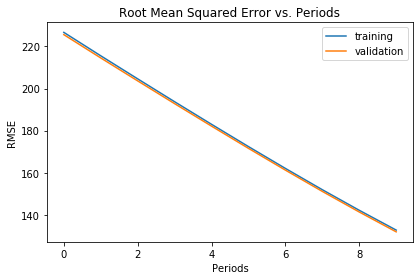

In [15]:
#
# Your code here: add your features of choice as a list of quoted strings.
#
minimal_features = [
     "median_income",
     "rooms_per_person"
]

assert minimal_features, "You must select at least one feature!"

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

#
# Don't forget to adjust these parameters.
#
train_model(
    learning_rate=0.01,
    steps=500,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

 ### 解决方案

点击下方即可查看解决方案。

Training model...
RMSE (on training data):
  period 00 : 165.92
  period 01 : 123.55
  period 02 : 117.23
  period 03 : 116.10
  period 04 : 115.43
  period 05 : 114.74
  period 06 : 114.05
  period 07 : 113.62
  period 08 : 113.10
  period 09 : 112.85
Model training finished.


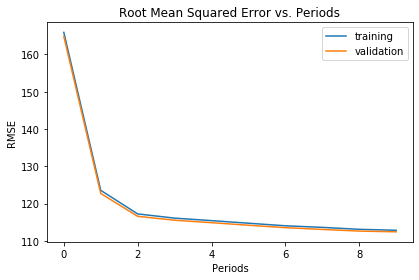

In [10]:
minimal_features = [
  "median_income",
  "latitude",
]

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

_ = train_model(
    learning_rate=0.01,
    steps=500,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

 ## 任务 2：更好地利用纬度

绘制 `latitude` 与 `median_house_value` 的图形后，表明两者确实不存在线性关系。

不过，有几个峰值与洛杉矶和旧金山大致相对应。

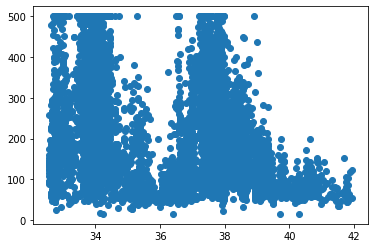

In [11]:
plt.scatter(training_examples["latitude"], training_targets["median_house_value"])

 **尝试创建一些能够更好地利用纬度的合成特征。**

例如，您可以创建某个特征，将 `latitude` 映射到值 `|latitude - 38|`，并将该特征命名为 `distance_from_san_francisco`。

或者，您可以将该空间分成 10 个不同的分桶（例如 `latitude_32_to_33`、`latitude_33_to_34` 等）：如果 `latitude` 位于相应分桶范围内，则显示值 `1.0`；如果不在范围内，则显示值 `0.0`。

使用相关矩阵来指导您构建合成特征；如果您发现效果还不错的合成特征，可以将其添加到您的模型中。

您可以获得的最佳验证效果是什么？

Training model...
RMSE (on training data):
  period 00 : 165.76
  period 01 : 123.97
  period 02 : 116.67
  period 03 : 115.94
  period 04 : 115.31
  period 05 : 114.93
  period 06 : 114.21
  period 07 : 113.78
  period 08 : 113.25
  period 09 : 112.65
Model training finished.


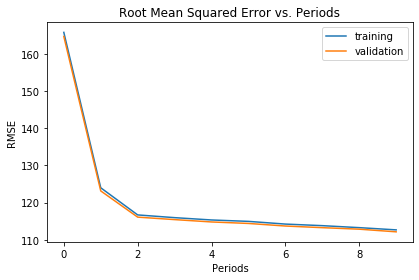

In [18]:
#
# YOUR CODE HERE: Train on a new data set that includes synthetic features based on latitude.
#
training_examples["distance_from_san_francisco"] = abs(training_examples["latitude"]-38)
validation_examples["distance_from_san_francisco"] = abs(validation_examples["latitude"]-38)
minimal_features = [
  "median_income",
  "latitude",
  "distance_from_san_francisco"
]

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

_ = train_model(
    learning_rate=0.01,
    steps=500,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

 ### 解决方案

点击下方即可查看解决方案。

 除了 `latitude` 之外，我们还会保留 `median_income`，以便与之前的结果进行比较。

我们决定对纬度进行分桶。在 Pandas 中使用 `Series.apply` 执行此操作相当简单。

In [0]:
LATITUDE_RANGES = zip(range(32, 44), range(33, 45))

def select_and_transform_features(source_df):
  selected_examples = pd.DataFrame()
  selected_examples["median_income"] = source_df["median_income"]
  for r in LATITUDE_RANGES:
    selected_examples["latitude_%d_to_%d" % r] = source_df["latitude"].apply(
      lambda l: 1.0 if l >= r[0] and l < r[1] else 0.0)
  return selected_examples

selected_training_examples = select_and_transform_features(training_examples)
selected_validation_examples = select_and_transform_features(validation_examples)

In [10]:
selected_training_examples

,median_income,latitude_32_to_33,latitude_33_to_34,latitude_34_to_35,latitude_35_to_36,latitude_36_to_37,latitude_37_to_38,latitude_38_to_39,latitude_39_to_40,latitude_40_to_41,latitude_41_to_42,latitude_42_to_43,latitude_43_to_44
6526,3.7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16507,3.8,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
14413,4.9,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
12607,4.9,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
15024,2.3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5669,3.7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9087,2.9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4570,2.6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13584,4.8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
_ = train_model(
    learning_rate=0.01,
    steps=500,
    batch_size=5,
    training_examples=selected_training_examples,
    training_targets=training_targets,
    validation_examples=selected_validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):


ValueError: ignored